In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from deeptime.decomposition.deep import TAE
from deeptime.decomposition.deep import TVAE
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import TVAEEncoder
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
soap_saved = np.load("assets/test2.npy")

In [3]:
soap_saved.shape

(40, 8000, 324)

In [4]:
data = np.concatenate(soap_saved)
scaler = MinMaxScaler()
scaler.fit(data)
scaled = scaler.transform(data)

In [ ]:
# ## We can save the scaler
# import joblib
# joblib.dump(scaler, "./assets/scaler.save")

In [ ]:
dataset = TrajectoryDataset(0, torch.Tensor(scaled))
n_val = int(len(dataset)*.25)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
loader_train = DataLoader(train_data, batch_size=256, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
units = [324, 1024, 256, 2]
# encoder = MLP(units, nonlinearity=torch.nn.ELU, output_nonlinearity=None, initial_batchnorm=True
#               )
encoder = TVAEEncoder(units, nonlinearity=torch.nn.ELU, initial_batchnorm=False)
encoder.to('cuda')
decoder = MLP(units[::-1], nonlinearity=torch.nn.ELU, initial_batchnorm=True)
decoder.to('cuda')
tae = TVAE(encoder, decoder, learning_rate=1e-4, device="cuda", beta=0.0)
tae.fit(loader_train, n_epochs=25, validation_loader=loader_val)
tae_model = tae.fetch_model()

In [9]:
## To save the model along with the training parameters
# save_path = "tvae_model.pt"

# checkpoint = {
#     "encoder_state_dict": tae._encoder.state_dict(),
#     "decoder_state_dict": tae._decoder.state_dict(),
#     "units": units,
#     "beta": tae._beta,
#     "learning_rate": tae.learning_rate,
# }

# torch.save(checkpoint, save_path)

# print(f"Model saved to {save_path}")


In [10]:
proj

array([[ 1.6037756,  3.039713 ],
       [ 1.4950757,  2.8619418],
       [ 1.4786508,  3.0700488],
       ...,
       [-1.0623037, -1.5568538],
       [-1.0280269, -1.6002992],
       [-0.7810654, -1.0755507]], dtype=float32)

Text(0, 0.5, '$\\mu_2$')

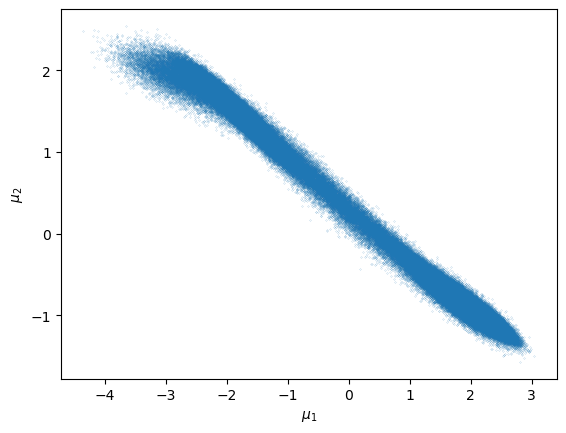

In [12]:
proj = tae_model.transform(scaled)
# fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(proj[:, 0][::1], proj[:, 1][::1],s = 0.01)
plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")

In [13]:
al2cu = np.load("./assets/min0K_relaxed_Al2Cu_soap.npy")
test_proj_al2cu = tae_model.transform(scaler.transform(np.concatenate(al2cu)))
fcc = np.load("./assets/min0K_relaxed_FCC_soap.npy")
test_proj_fcc = tae_model.transform(scaler.transform(np.concatenate(fcc)))
ni3p = np.load("./assets/min0K_relaxed_Ni3P_soap.npy")
test_proj_ni3p = tae_model.transform(scaler.transform(np.concatenate(ni3p)))

Text(0, 0.5, '$\\mu_2$')

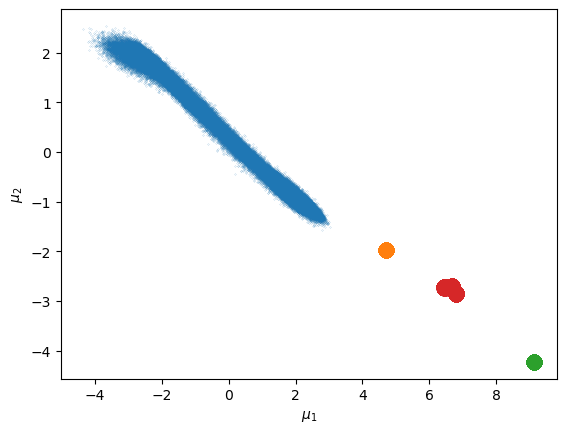

In [14]:
proj = tae_model.transform(scaled)
# fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(proj[:, 0][::1], proj[:, 1][::1],s = 0.01)
plt.scatter(test_proj_al2cu[:, 0], test_proj_al2cu[:, 1], s=100, alpha=1.0)
plt.scatter(test_proj_fcc[:, 0], test_proj_fcc[:, 1], s=100, alpha=1.0)
plt.scatter(test_proj_ni3p[:, 0], test_proj_ni3p[:, 1], s=100, alpha=1.0)
plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")